Reset 后的初始位置（保留两位小数）：[0.55, 0.4, -0.05, -0.1, -0.7]


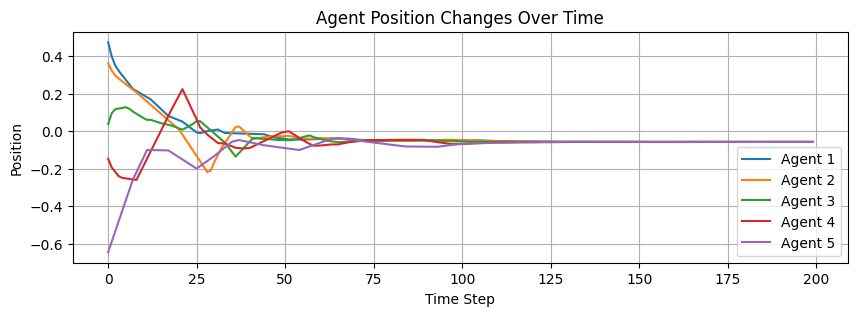

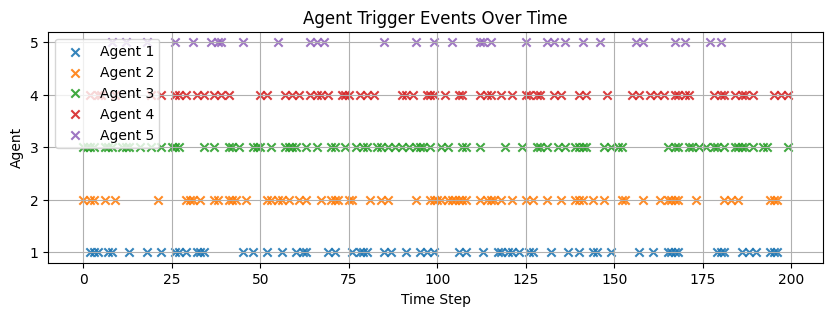

Actions History:
[0, 1, 1, 0, 0]
[0, 0, 1, 0, 0]
[1, 1, 1, 1, 0]
[1, 1, 1, 0, 0]
[1, 0, 0, 1, 0]
[0, 0, 0, 1, 0]
[0, 1, 1, 0, 0]
[1, 0, 1, 0, 0]
[1, 0, 1, 0, 1]
[0, 1, 0, 1, 0]
[0, 0, 0, 0, 0]
[0, 0, 1, 0, 0]
[0, 0, 1, 0, 1]
[1, 0, 1, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 1, 0, 0]
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 1]
[0, 0, 1, 1, 0]
[0, 0, 0, 0, 0]
[0, 1, 0, 0, 0]
[1, 0, 1, 1, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 1, 0, 0]
[1, 0, 1, 1, 1]
[1, 0, 1, 1, 0]
[0, 0, 0, 0, 0]
[1, 1, 0, 1, 0]
[0, 1, 0, 0, 0]
[0, 1, 0, 0, 1]
[1, 0, 0, 1, 0]
[1, 1, 0, 0, 0]
[1, 0, 1, 1, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 1]
[0, 1, 1, 1, 0]
[0, 1, 0, 0, 1]
[0, 0, 0, 1, 1]
[0, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
[0, 1, 1, 0, 0]
[0, 1, 0, 0, 0]
[0, 0, 1, 0, 0]
[1, 0, 0, 0, 1]
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[1, 0, 1, 0, 0]
[0, 0, 1, 0, 0]
[0, 0, 1, 1, 0]
[0, 0, 0, 0, 0]
[1, 1, 0, 1, 0]
[0, 1, 1, 0, 0]
[0, 0, 0, 0, 0]
[0, 1, 0, 0, 1]
[1, 1, 0, 0, 0]
[0, 0, 1, 1, 0]
[0, 1, 1, 0, 0]
[0, 0, 1, 1, 0]
[1, 0, 1, 0, 0]
[0, 1, 

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from env_new.MAenv_3 import CustomMAEnvironment3

# 定义 PolicyNetwork
class PolicyNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size=64):
        super(PolicyNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

# 加载策略函数
def load_policies(env, policies_path):
    agents = env.agents
    policies = {}
    for agent in agents:
        policy = PolicyNetwork(
            env.observation_space(agent).shape[0],
            env.action_space(agent).n
        )
        policy.load_state_dict(torch.load(f"{policies_path}/{agent}_policy.pth"))
        policy.eval()  # 设置为评估模式
        policies[agent] = policy
    return policies

# 模拟代码
def simulate_env(env, policies, num_steps=200):
    obs = env.reset()
    print(f"Reset 后的初始位置（保留两位小数）：{env.initial_positions}")
    agents = env.agents
    
    actions_history = []
    positions_history = np.zeros((num_steps, len(agents)))
    
    for t in range(num_steps):
        actions = {}
        for agent in agents:
            obs_tensor = torch.FloatTensor(obs[agent]).unsqueeze(0)
            with torch.no_grad():
                logits = policies[agent](obs_tensor)
            probs = torch.softmax(logits, dim=-1)
            action = torch.multinomial(probs, 1).item()
            actions[agent] = action

        # 保存当前时间步的动作选择
        actions_history.append([actions[agent] for agent in agents])
        
        # 环境交互
        obs, _, _, _ = env.step(actions)
        
        # 保存当前时间步的智能体位置
        for i, agent in enumerate(agents):
            positions_history[t, i] = env.agent_objs[i].position
    
    return actions_history, positions_history

# 可视化函数
def plot_results(actions_history, positions_history, env):
    # 绘制智能体位置变化
    plt.figure(figsize=(10, 3))
    for i, agent in enumerate(env.agents):
        plt.plot(positions_history[:, i], label=f"Agent {i+1}")
    plt.xlabel("Time Step")
    plt.ylabel("Position")
    plt.title("Agent Position Changes Over Time")
    plt.legend()
    plt.grid()
    plt.show()

    # 绘制触发情况
    plt.figure(figsize=(10, 3))
    for i, agent in enumerate(env.agents):
        triggers = [t for t, action in enumerate(actions_history) if action[i] == 1]
        plt.scatter(triggers, [i+1] * len(triggers), label=f"Agent {i+1}", alpha=0.9, marker='x')  # 修改为 'x'
    plt.xlabel("Time Step")
    plt.ylabel("Agent")
    plt.title("Agent Trigger Events Over Time")
    plt.yticks(range(1, len(env.agents)+1))
    plt.grid()
    plt.legend()
    plt.show()

# 主函数
if __name__ == "__main__":
    # 创建环境
    env = CustomMAEnvironment3(num_agents=5, num_iterations=200, dt=0.1)

    
    # 加载策略
    policies = load_policies(env, policies_path=".")
    
    # 模拟环境交互
    actions_history, positions_history = simulate_env(env, policies)

    # 绘制结果
    plot_results(actions_history, positions_history, env)
    
    # 输出所有动作选择矩阵
    print("Actions History:")
    for actions in actions_history:
        print(actions)
    
    

Reset 后的初始位置（保留两位小数）：[-0.46 -0.54  0.21 -0.32  0.35]
Trigger Counts:
agent_0: 86
agent_1: 95
agent_2: 89
agent_3: 93
agent_4: 85
Total Triggers Across All Agents: 448


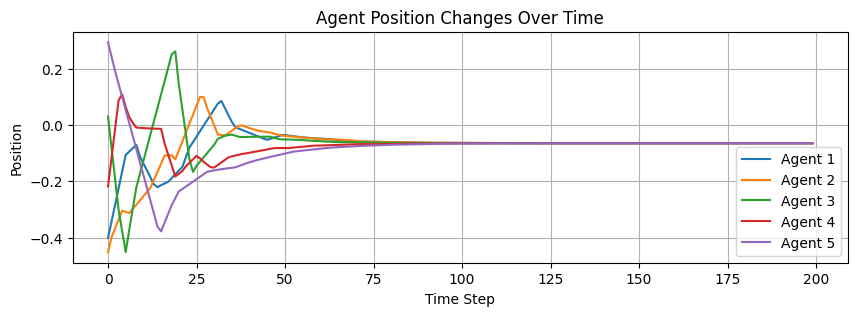

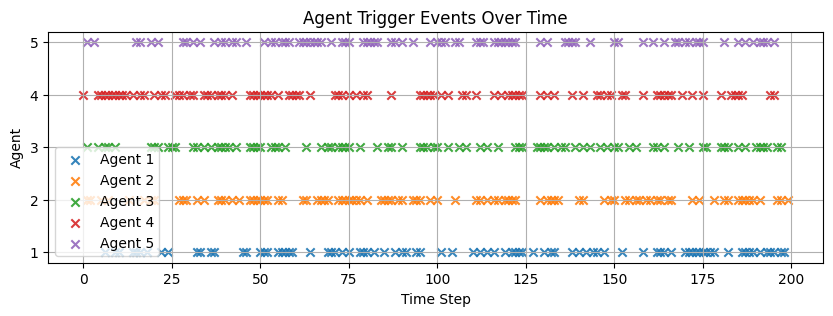

Actions History:
[0, 0, 0, 1, 0]
[0, 1, 1, 0, 1]
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 1]
[0, 0, 1, 1, 0]
[0, 1, 0, 1, 0]
[1, 0, 1, 1, 0]
[0, 1, 1, 1, 0]
[0, 0, 0, 1, 0]
[1, 0, 1, 1, 0]
[1, 0, 0, 1, 0]
[0, 0, 0, 1, 0]
[0, 0, 0, 1, 0]
[0, 1, 0, 0, 0]
[1, 0, 0, 1, 0]
[1, 0, 0, 0, 1]
[1, 0, 0, 1, 1]
[0, 1, 0, 1, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 0, 1]
[0, 1, 1, 1, 0]
[0, 0, 1, 0, 1]
[1, 0, 0, 1, 0]
[0, 0, 0, 1, 0]
[1, 0, 1, 0, 0]
[0, 0, 1, 0, 0]
[0, 0, 1, 1, 0]
[0, 1, 0, 1, 0]
[0, 1, 0, 1, 1]
[0, 1, 0, 0, 1]
[0, 0, 0, 1, 0]
[0, 0, 1, 1, 1]
[1, 1, 1, 0, 0]
[1, 0, 0, 0, 1]
[0, 1, 1, 1, 0]
[0, 0, 0, 1, 0]
[1, 0, 1, 1, 0]
[1, 0, 0, 0, 1]
[0, 1, 1, 1, 0]
[0, 1, 1, 1, 1]
[0, 1, 1, 1, 1]
[0, 0, 1, 0, 0]
[0, 1, 0, 1, 1]
[0, 0, 1, 0, 1]
[0, 1, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 1]
[0, 1, 1, 1, 0]
[0, 1, 1, 1, 0]
[0, 1, 1, 1, 0]
[1, 1, 1, 1, 0]
[1, 1, 0, 1, 1]
[1, 1, 0, 1, 0]
[0, 0, 1, 1, 1]
[0, 0, 1, 0, 1]
[1, 1, 1, 1, 0]
[1, 1, 0, 0, 1]
[1, 0, 1, 0, 1]
[1, 0, 0, 1, 1]
[1, 0, 0, 1, 0]
[0, 0, 0, 1, 0]
[0, 0, 

In [84]:
#lstm网络

import torch
import numpy as np
import matplotlib.pyplot as plt
from env_new.MAenv_3 import CustomMAEnvironment3

# 定义 RecurrentPolicy
class RecurrentPolicy(torch.nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim):
        super(RecurrentPolicy, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = torch.nn.LSTM(input_dim, hidden_size, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_dim)

    def forward(self, x, h_c):
        """
        x 的维度: (batch_size, seq_len, input_dim)
        h_c 为 (h0, c0)，它们的维度都是 (num_layers, batch_size, hidden_size)
        """
        out, (hn, cn) = self.lstm(x, h_c)  # out: (batch_size, seq_len, hidden_size)
        logits = self.fc(out)             # (batch_size, seq_len, output_dim)
        return logits, (hn, cn)

    def init_hidden(self, batch_size=1):
        """
        初始化隐藏状态和细胞状态 (h0, c0) 维度:
          (1, batch_size, hidden_size)
        """
        return (torch.zeros(1, batch_size, self.hidden_size),
                torch.zeros(1, batch_size, self.hidden_size))

# 加载 RecurrentPolicy 的策略
def load_recurrent_policies(env, policies_path, hidden_size):
    agents = env.agents
    policies = {}
    for agent in agents:
        policy = RecurrentPolicy(
            env.observation_space(agent).shape[0],
            hidden_size,
            env.action_space(agent).n
        )
        policy.load_state_dict(torch.load(f"{policies_path}/{agent}_policy_lstm.pth"))
        policy.eval()  # 设置为评估模式
        policies[agent] = policy
    return policies

# 模拟环境交互
def simulate_env(env, policies, hidden_size, num_steps=200):
    obs = env.reset()
    print(f"Reset 后的初始位置（保留两位小数）：{env.initial_positions}")
    agents = env.agents
    
    actions_history = []
    positions_history = np.zeros((num_steps, len(agents)))
    
    # 初始化每个智能体的隐状态
    hidden_states = {agent: policies[agent].init_hidden(batch_size=1) for agent in agents}
    
    # 初始化触发统计
    trigger_counts = {agent: 0 for agent in agents}
    
    for t in range(num_steps):
        actions = {}
        for agent in agents:
            obs_tensor = torch.FloatTensor(obs[agent]).view(1, 1, -1)  # shape: (1, 1, obs_dim)
            with torch.no_grad():
                logits, hidden_states[agent] = policies[agent](obs_tensor, hidden_states[agent])
            probs = torch.softmax(logits[:, -1, :], dim=-1)  # 取最后一个时间步的 softmax
            action = torch.multinomial(probs, 1).item()
            actions[agent] = action
            
            # 如果动作是触发动作（例如动作值为 1），增加计数
            if action == 1:
                trigger_counts[agent] += 1

        # 保存当前时间步的动作选择
        actions_history.append([actions[agent] for agent in agents])
        
        # 环境交互
        obs, _, _, _ = env.step(actions)
        
        # 保存当前时间步的智能体位置
        for i, agent in enumerate(agents):
            positions_history[t, i] = env.agent_objs[i].position
    
    return actions_history, positions_history, trigger_counts

# 主函数
if __name__ == "__main__":
    # 创建环境
    env = CustomMAEnvironment3(num_agents=5, num_iterations=200, dt=0.1)

    # 加载 LSTM 策略
    hidden_size = 64
    policies = load_recurrent_policies(env, policies_path=".", hidden_size=hidden_size)
    
    # 模拟环境交互
    actions_history, positions_history, trigger_counts = simulate_env(env, policies, hidden_size)
        
    # 输出每个智能体的总触发次数
    print("Trigger Counts:")
    for agent, count in trigger_counts.items():
        print(f"{agent}: {count}")
    
    # 输出所有智能体触发次数的总和
    total_triggers = sum(trigger_counts.values())
    print(f"Total Triggers Across All Agents: {total_triggers}")

    # 绘制结果
    plot_results(actions_history, positions_history, env)
    
    # 输出所有动作选择矩阵
    print("Actions History:")
    for actions in actions_history:
        print(actions)



Reset 后的初始位置（保留两位小数）：[0.55, 0.4, -0.05, -0.1, -0.7]


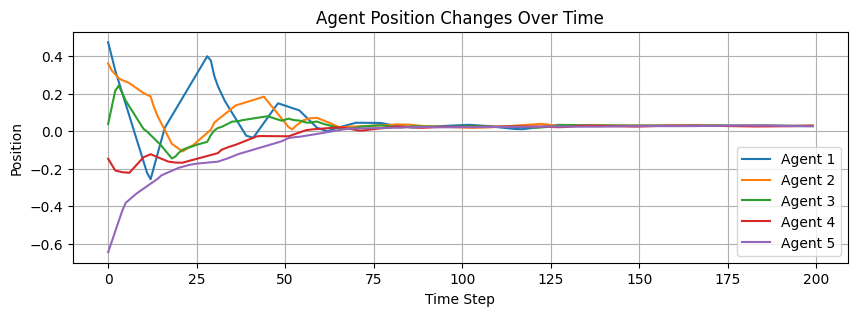

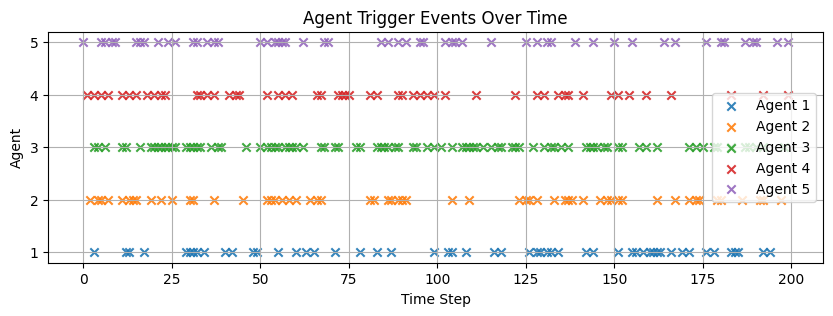

Actions History:
[0, 0, 0, 0, 1]
[0, 0, 0, 1, 0]
[0, 1, 0, 0, 0]
[1, 0, 1, 1, 0]
[0, 1, 1, 0, 0]
[0, 1, 0, 1, 1]
[0, 0, 1, 0, 1]
[0, 1, 0, 1, 0]
[0, 0, 0, 0, 1]
[0, 0, 0, 0, 1]
[0, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
[1, 0, 1, 0, 0]
[1, 1, 0, 1, 0]
[0, 1, 0, 0, 0]
[0, 1, 0, 1, 1]
[0, 0, 1, 0, 1]
[1, 0, 0, 0, 1]
[0, 0, 0, 1, 0]
[0, 1, 1, 0, 0]
[0, 0, 1, 1, 0]
[0, 0, 1, 0, 1]
[0, 1, 1, 1, 0]
[0, 0, 1, 1, 0]
[0, 0, 1, 0, 1]
[0, 1, 1, 0, 0]
[0, 0, 1, 0, 1]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[1, 0, 1, 0, 0]
[1, 1, 1, 0, 0]
[1, 1, 1, 0, 1]
[1, 0, 1, 1, 1]
[0, 0, 1, 1, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 1, 1]
[0, 0, 1, 0, 0]
[0, 1, 0, 1, 1]
[0, 0, 1, 0, 1]
[0, 0, 1, 0, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 1, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 1, 0]
[0, 0, 0, 1, 0]
[0, 1, 0, 0, 0]
[0, 0, 1, 0, 0]
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 0, 1, 0, 1]
[0, 0, 0, 0, 0]
[0, 1, 1, 1, 1]
[0, 1, 1, 0, 0]
[0, 1, 1, 0, 1]
[1, 0, 1, 1, 1]
[0, 1, 0, 0, 1]
[0, 0, 1, 1, 1]
[0, 1, 1, 0, 0]
[0, 0, 1, 1, 0]
[1, 1, 1, 0, 0]
[0, 0, 

In [52]:
#共享网络

import torch
import numpy as np
import matplotlib.pyplot as plt
from env_new.MAenv_shared import CustomMAEnvironment

# 定义 PolicyNetwork
class PolicyNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size=64):
        super(PolicyNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

def load_shared_policy(env, policy_path="shared_policy.pth"):
    """
    加载一个共享的策略网络。假设所有Agent的观测维度和动作维度相同。
    """
    # 以第一个智能体的观测动作空间作为参考
    first_agent = env.agents[0]
    obs_dim = env.observation_space(first_agent).shape[0]
    act_dim = env.action_space(first_agent).n

    # 创建并加载权重
    policy = PolicyNetwork(obs_dim, act_dim)
    policy.load_state_dict(torch.load(policy_path))
    policy.eval()  # 设置为评估模式
    return policy

def simulate_env(env, shared_policy, num_steps=200):
    obs = env.reset()
    print(f"Reset 后的初始位置（保留两位小数）：{env.initial_positions}")
    agents = env.agents
    
    actions_history = []
    positions_history = np.zeros((num_steps, len(agents)))
    
    for t in range(num_steps):
        actions = {}
        for i, agent in enumerate(agents):
            # 同一个网络，根据各自的obs选取动作
            obs_tensor = torch.FloatTensor(obs[agent]).unsqueeze(0)
            with torch.no_grad():
                logits = shared_policy(obs_tensor)
            probs = torch.softmax(logits, dim=-1)
            action = torch.multinomial(probs, 1).item()
            actions[agent] = action

        actions_history.append([actions[agent] for agent in agents])
        
        # 环境交互
        obs, _, _, _ = env.step(actions)
        
        # 保存当前时间步的智能体位置
        for i, agent in enumerate(agents):
            positions_history[t, i] = env.agent_objs[i].position
    
    return actions_history, positions_history

def plot_results(actions_history, positions_history, env):
    # 绘制智能体位置变化
    plt.figure(figsize=(10, 3))
    for i, agent in enumerate(env.agents):
        plt.plot(positions_history[:, i], label=f"Agent {i+1}")
    plt.xlabel("Time Step")
    plt.ylabel("Position")
    plt.title("Agent Position Changes Over Time")
    plt.legend()
    plt.grid()
    plt.show()

    # 绘制触发情况
    plt.figure(figsize=(10, 3))
    for i, agent in enumerate(env.agents):
        triggers = [t for t, action in enumerate(actions_history) if action[i] == 1]
        plt.scatter(triggers, [i+1] * len(triggers), label=f"Agent {i+1}", alpha=0.9, marker='x')
    plt.xlabel("Time Step")
    plt.ylabel("Agent")
    plt.title("Agent Trigger Events Over Time")
    plt.yticks(range(1, len(env.agents)+1))
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    # 创建环境
    env = CustomMAEnvironment(num_agents=5, num_iterations=200, dt=0.1)
    
    # 加载共享策略网络
    shared_policy = load_shared_policy(env, policy_path="new_policy_with_intervention.pth")
    
    # 模拟环境交互
    actions_history, positions_history = simulate_env(env, shared_policy, num_steps=200)

    # 绘制结果
    plot_results(actions_history, positions_history, env)
    
    # 输出所有动作选择矩阵
    print("Actions History:")
    for actions in actions_history:
        print(actions)
